<a href="https://colab.research.google.com/github/islammohamedd1/gp/blob/main/multi_stock/stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stocks Prediction

In [1]:
import IPython
import IPython.display

%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Bidirectional, Dropout, BatchNormalization, Reshape
from tensorflow.keras.utils import plot_model 
import re

In [2]:
matplotlib.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.figsize'] = [12, 8]

## Data

In [3]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')


In [4]:
def create_stock_df(prices_path='/content/drive/MyDrive/GP/Datasets/nflx_prices.csv', news_path='/content/drive/MyDrive/GP/Datasets/analyzed_news.csv', stock_symbol='NFLX'):
    df = pd.read_csv(prices_path, index_col='Date', parse_dates=['Date'], date_parser=dateparse)
    # print('prices rows count:', len(df))
    
    df = df.rename(columns={'Open': 'open', 'Close': 'close', 'High': 'high', 'Low': 'low', 'Volume': 'volume'})
    df = df.drop(columns=['Adj Close'])

    # print('prices description')
    # print(df.describe())

    df['change'] = df.close.pct_change()
    df.dropna(inplace=True)

    news_df = pd.read_csv(news_path, index_col=0, parse_dates=['date'], date_parser=dateparse)
    news_df = news_df.where(news_df['stock'] == stock_symbol).dropna()
    # print('news rows count', len(news_df))

    news_df['sentiment'] = news_df['sentiment'].apply(lambda x: float(re.findall('\d+\.\d+', x)[0]))

    grouped_df = pd.DataFrame(news_df.groupby(['date']).mean())

    df = df.join(grouped_df)

    # print('Days with no sentiment', df['sentiment'].isna().sum())

    df['sentiment'].fillna(-1, inplace=True)

    df.drop(columns=['open', 'high', 'low'], inplace=True)

    scaler = MinMaxScaler()
    df.close = scaler.fit_transform(df.close.values.reshape(-1, 1))
    df.volume = scaler.fit_transform(df.volume.values.reshape(-1, 1))
    df.change = scaler.fit_transform(df.change.values.reshape(-1, 1))
    
    return df

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## News Data

In [6]:
news_df = pd.read_csv('/content/drive/MyDrive/GP/Datasets/analyzed_news.csv', index_col=0, parse_dates=['date'], date_parser=dateparse)
news_df.head()

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,title,date,stock,sentiment
0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
1,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
2,71 Biggest Movers From Friday,2020-05-26,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
3,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."
4,B of A Securities Maintains Neutral on Agilent...,2020-05-22,A,"(<tf.Tensor: shape=(), dtype=float32, numpy=0...."


In [7]:
# news_df.groupby(['stock']).count().sort_values(by=['date'], ascending=False).head(50)

## Grouping the data

In [8]:
data = {}
data['nflx'] = create_stock_df(prices_path='/content/drive/My Drive/GP/Datasets/nflx_prices.csv', stock_symbol='NFLX')
data['mrk'] = create_stock_df(prices_path='/content/drive/My Drive/GP/Datasets/mrk_prices.csv', stock_symbol='MRK')
data['ms'] = create_stock_df(prices_path='/content/drive/My Drive/GP/Datasets/ms_prices.csv', stock_symbol='MS')
data['mu'] = create_stock_df(prices_path='/content/drive/My Drive/GP/Datasets/mu_prices.csv', stock_symbol='MU')
data['nvda'] = create_stock_df(prices_path='/content/drive/My Drive/GP/Datasets/nvda_prices.csv', stock_symbol='NVDA')
data['qqq'] = create_stock_df(prices_path='/content/drive/My Drive/GP/Datasets/qqq_prices.csv', stock_symbol='QQQ')
data['ebay'] = create_stock_df(prices_path='/content/drive/My Drive/GP/Datasets/ebay_prices.csv', stock_symbol='EBAY')

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar inst

In [9]:
num_features = data['nflx'].shape[1]
num_features

4

In [10]:
train_data = [data['nflx'], data['mrk'], data['ms']]
val_data = [data['mu'], data['nvda'], data['qqq']]
test_data = data['ebay']

## Window Generator

In [11]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, train_df, label_columns=None):
        # Store the raw data
        self.train_df = train_df
        
        # wirk out the label column indices
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i,
                                          name in enumerate(label_columns)}
        self.column_indices = {name: i for i,
                               name in enumerate(train_df.columns)}
        
        # work out the window parameters
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        
        self.total_window_size = input_width + shift
        
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
        
    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

In [12]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=256,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [13]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.example = example

In [14]:
def plot(self, model=None, plot_col='close', max_subplots=3, title=None):
    inputs, labels = self.example
    # plt.figure(figsize=(24, 32))
    if title:
        plt.suptitle(title)
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(max_subplots, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                        marker='X', edgecolors='k', label='Predictions',
                        c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()
    
    plt.xlabel('Time')
    plt.show()

WindowGenerator.plot = plot

In [15]:
def plot_series(self, model, series, plot_col='close', start=0, title=None):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(self.total_window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(self.total_window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    forecast = forecast[:-1, -1, 0]
    plt.plot(np.array(range(len(series[plot_col][start + self.label_width:]))), 
                series[plot_col][start + self.label_width:], '-')
    plt.plot(np.array(range(len(forecast[start + self.label_width:]))), forecast[start + self.label_width:], '-')

    plt.title(title)
    plt.legend(['Actual', 'Prediction'])
    plt.xlabel('Time')
    plt.show()

        
WindowGenerator.plot_series = plot_series

In [16]:
val_performance = {}
performance = {}

In [17]:
MAX_EPOCHS = 1000

def compile_and_fit(model, train, val, patience=5):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                      patience=patience,
                                                      mode='min',
                                                      restore_best_weights=True)

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(),
                         tf.metrics.MeanAbsolutePercentageError()])

    history = model.fit(train, epochs=MAX_EPOCHS,
                    #   validation_data=val,
                      callbacks=[early_stopping])
    return history

## Models

### Window the data

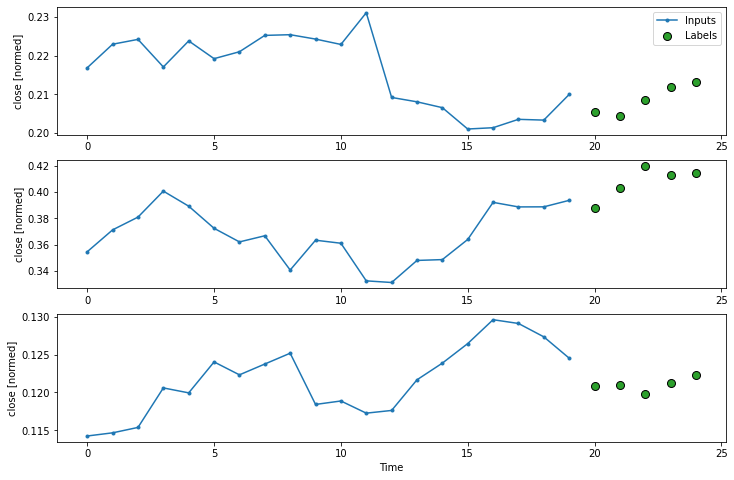

In [18]:
OUT_STEPS = 5
WINDOW_INPUT_WIDTH = 20

train_windows = list(map(lambda x: WindowGenerator(input_width=WINDOW_INPUT_WIDTH, label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['close'], train_df=x), train_data))

val_windows = list(map(lambda x: WindowGenerator(input_width=WINDOW_INPUT_WIDTH, label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['close'], train_df=x), val_data))

test_window = WindowGenerator(input_width=WINDOW_INPUT_WIDTH, label_width=OUT_STEPS,
                               shift=OUT_STEPS, label_columns=['close'], train_df=test_data)

train_windows[0].plot()

In [19]:
multi_val_performance = {}
multi_performance = {}

### Dense model

In [20]:
multi_dense_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

for t, v in zip(train_windows, val_windows):
    history = compile_and_fit(multi_dense_model, train=t.train, val=v.train)

IPython.display.clear_output()
multi_performance['Dense'] = multi_dense_model.evaluate(test_window.train, verbose=0)

In [21]:
# plot_model(multi_dense_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

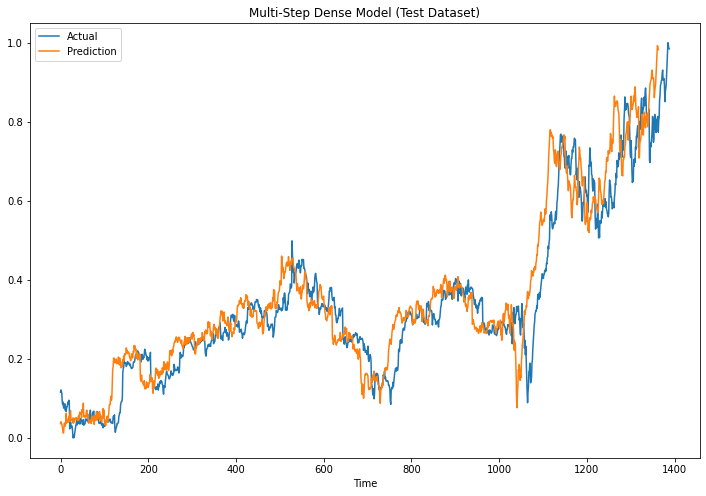

In [22]:
test_window.plot_series(multi_dense_model, title="Multi-Step Dense Model (Test Dataset)", series=test_data, start=0)
# multi_window.plot_series(multi_dense_model, title="Multi-Step Dense Model (Test Dataset) A Closer Look", start=-100)

### CNN

In [23]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    tf.keras.layers.Conv1D(512, activation='relu', kernel_size=(CONV_WIDTH)),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

for t, v in zip(train_windows, val_windows):
    history = compile_and_fit(multi_conv_model, train=t.train, val=v.train)

IPython.display.clear_output()

multi_performance['Conv'] = multi_conv_model.evaluate(test_window.train, verbose=0)

In [24]:
# plot_model(multi_conv_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

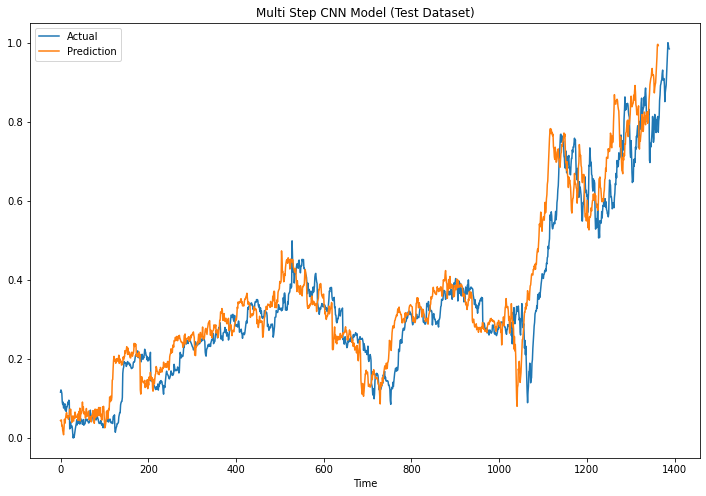

In [25]:
test_window.plot_series(multi_conv_model, title="Multi Step CNN Model (Test Dataset)", series=test_data, start=0)

### RNN LSTM

In [26]:
tf.keras.backend.clear_session()
multi_lstm_model = tf.keras.Sequential([
    LSTM(1024, return_sequences=True),
    Dropout(0.5),
    LSTM(512, return_sequences=False),
    Dropout(0.5),
    Dense(OUT_STEPS*num_features),
    Reshape([OUT_STEPS, num_features])
])

for t, v in zip(train_windows, val_windows):
    history = compile_and_fit(multi_lstm_model, train=t.train, val=v.train)

IPython.display.clear_output()

multi_performance['LSTM'] = multi_lstm_model.evaluate(test_window.train, verbose=0)

In [27]:
# plot_model(multi_lstm_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

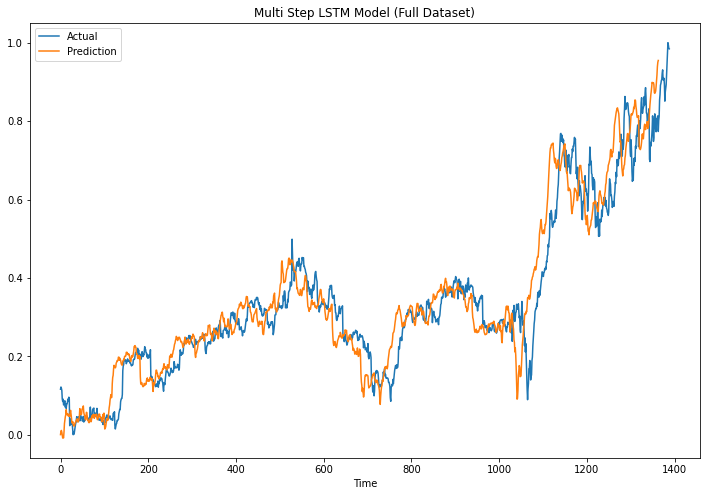

In [28]:
test_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Full Dataset)", series=test_data)
# multi_window.plot_series(multi_lstm_model, title="Multi Step LSTM Model (Test Dataset)", start=0)

### Bidirectional LSTM

In [29]:
tf.keras.backend.clear_session()
bidirectional_lstm_model = tf.keras.Sequential([
    Bidirectional(LSTM(1024, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(512, return_sequences=False)),
    Dropout(0.5),
    Dense(OUT_STEPS*num_features),
    Reshape([OUT_STEPS, num_features])
])

for t, v in zip(train_windows, val_windows):
    history = compile_and_fit(bidirectional_lstm_model, train=t.train, val=v.train)

IPython.display.clear_output()

multi_performance['BIDIRECTIONAL_LSTM'] = bidirectional_lstm_model.evaluate(test_window.train, verbose=0)

In [30]:
# plot_model(bidirectional_lstm_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

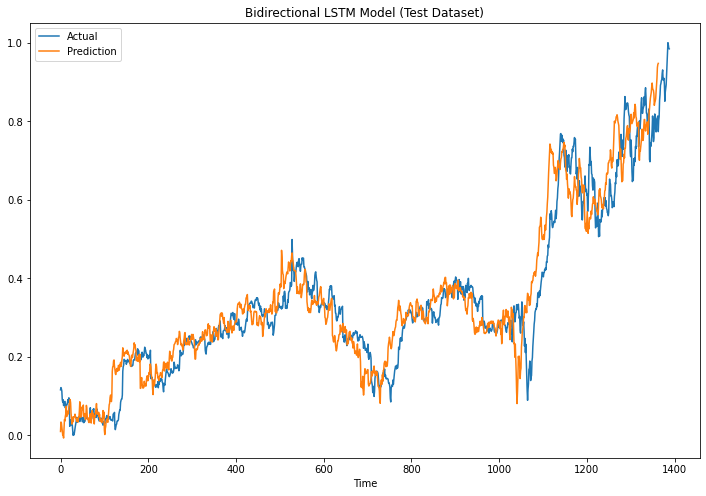

In [31]:
test_window.plot_series(bidirectional_lstm_model, title="Bidirectional LSTM Model (Test Dataset)", series=test_data)

### GRU

In [32]:
tf.keras.backend.clear_session()

gru_model = tf.keras.Sequential([
    GRU(2048, return_sequences=True),
    Dropout(0.5), ## Note the performance without dropout
    GRU(1024, return_sequences=False),
    Dropout(0.5),
    Dense(OUT_STEPS*num_features),
    Reshape([OUT_STEPS, num_features])
])

for t, v in zip(train_windows, val_windows):
    history = compile_and_fit(gru_model, train=t.train, val=v.train)

IPython.display.clear_output()

multi_performance['GRU'] = gru_model.evaluate(test_window.train, verbose=0)

In [33]:
# plot_model(gru_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [34]:
multi_performance['GRU']

[0.000838769949041307, 0.019743360579013824, 17544.7421875]

Prices Only:
[0.0016089612618088722, 0.0282294861972332, 3.2332615852355957]

--------

with change only
[0.0015077263815328479, 0.026979191228747368, 3.0844204425811768]

------

With Sentiment
[0.001484061824157834, 0.02578793279826641, 2.922233819961548]

change and sentiment
[0.0014610916841775179, 0.025688420981168747, 2.9213783740997314]


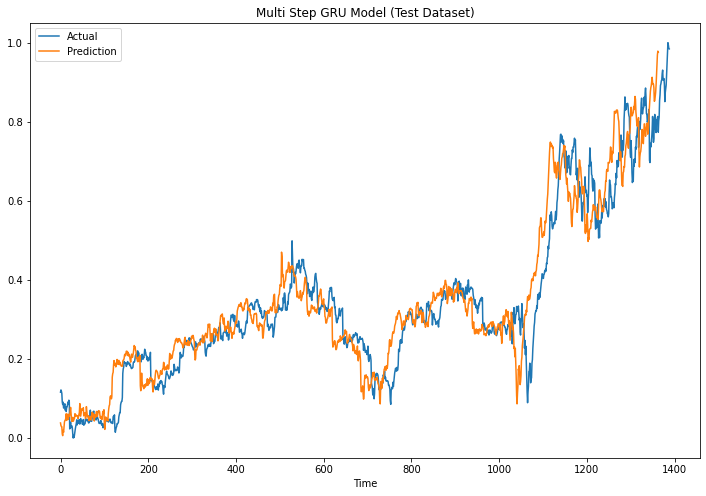

In [35]:
test_window.plot_series(gru_model, title="Multi Step GRU Model (Test Dataset)", series=test_data, start=0)

### Bidirectional GRU

In [36]:
tf.keras.backend.clear_session()

bidirectinoal_gru_model = tf.keras.Sequential([
    Bidirectional(GRU(2048, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(GRU(1024, return_sequences=False)),
    Dropout(0.5),
    Dense(OUT_STEPS*num_features),
    Reshape([OUT_STEPS, num_features])
])

for t, v in zip(train_windows, val_windows):
    history = compile_and_fit(bidirectinoal_gru_model, train=t.train, val=v.train)

IPython.display.clear_output()

multi_performance['Bidirectional_GRU'] = bidirectinoal_gru_model.evaluate(test_window.train, verbose=0)

In [37]:
# plot_model(bidirectinoal_gru_model, show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [38]:
multi_performance['Bidirectional_GRU']

[0.0008194965776056051, 0.0196856576949358, 12860.3408203125]

Prices Only
[0.0018332613399252295, 0.03330288827419281, 3.8212127685546875]

------

with change only
[0.0014874334447085857, 0.02773701213300228, 3.1589272022247314]


-------

change and sentiement
[0.0015775762731209397, 0.028502382338047028, 3.2571663856506348]


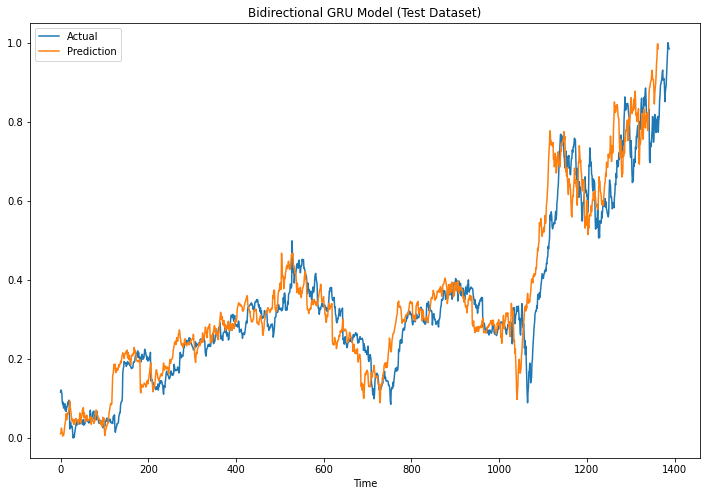

In [39]:
test_window.plot_series(bidirectinoal_gru_model, title="Bidirectional GRU Model (Test Dataset)", series=test_data, start=0)

## Summary

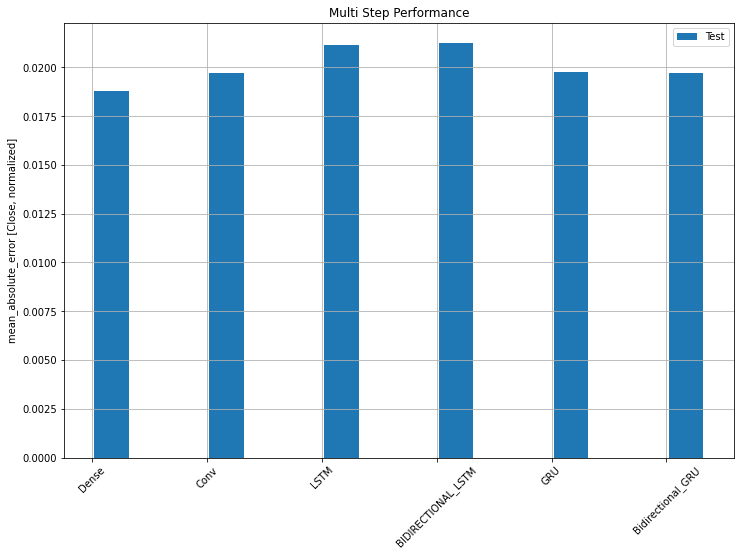

In [40]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.grid()
plt.title('Multi Step Performance')
plt.ylabel('mean_absolute_error [Close, normalized]')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()

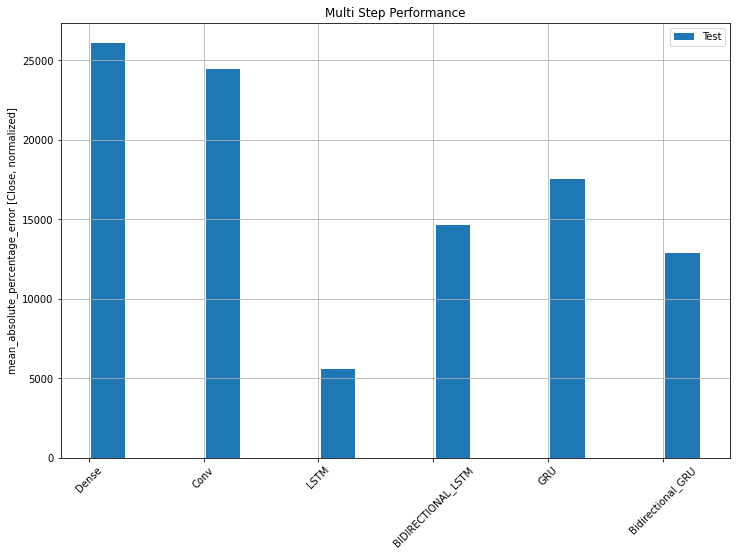

In [41]:
x = np.arange(len(multi_performance))
width = 0.3
metric_name = 'mean_absolute_percentage_error'
metric_index = multi_lstm_model.metrics_names.index('mean_absolute_percentage_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.grid()
plt.title('Multi Step Performance')
plt.ylabel('mean_absolute_percentage_error [Close, normalized]')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
_ = plt.legend()